In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, StandardScaler
import torch
import torch.nn as nn
import sys, os
sys.path.append(os.path.abspath("../src"))
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from node.lib.odst import ODST
from imblearn.over_sampling import SMOTE
import optuna

/opt/anaconda3/envs/sago/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Apply quantile transformation to features
qt = QuantileTransformer(output_distribution='normal')
X_transformed = qt.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [10]:
input_dim = X_train.shape[1]
num_classes = len(set(y_train))

model = nn.Sequential(
    ODST(
        in_features=input_dim,
        num_trees=64,
        depth=6,
        tree_dim=3,
        flatten_output=True
    ),
    nn.Linear(64 * 3, num_classes)
)

In [11]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/Users/ozgun/Desktop/cs454/CS454-Project/src/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


Epoch 1, Loss: 1.5628
Epoch 2, Loss: 1.2698
Epoch 3, Loss: 1.4403
Epoch 4, Loss: 1.0842
Epoch 5, Loss: 1.0987
Epoch 6, Loss: 1.1092
Epoch 7, Loss: 1.2033
Epoch 8, Loss: 1.0426
Epoch 9, Loss: 1.0728
Epoch 10, Loss: 1.0423


Accuracy: 0.5400
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.59      0.57      0.58       428
           6       0.52      0.69      0.60       567
           7       0.49      0.29      0.37       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.23      0.22      0.22      1300
weighted avg       0.50      0.54      0.51      1300



/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


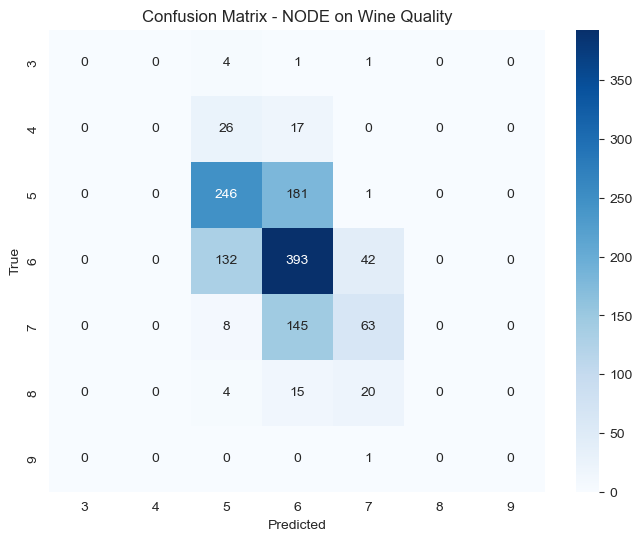

In [12]:
# Prepare test data
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_probs = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1).numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - NODE on Wine Quality")
plt.show()

/Users/ozgun/Desktop/cs454/CS454-Project/src/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


Epoch 1, Loss: 0.9999
Epoch 2, Loss: 0.7806
Epoch 3, Loss: 1.0383
Epoch 4, Loss: 1.3539
Epoch 5, Loss: 0.5442
Epoch 6, Loss: 0.6480
Epoch 7, Loss: 0.8745
Epoch 8, Loss: 0.7228
Epoch 9, Loss: 0.6946
Epoch 10, Loss: 0.5531
Accuracy: 0.5415
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.61      0.62      0.61       428
           6       0.51      0.75      0.61       567
           7       0.52      0.06      0.10       216
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.23      0.20      0.19      1300
weighted avg       0.51      0.54      0.48      1300



/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/sago/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


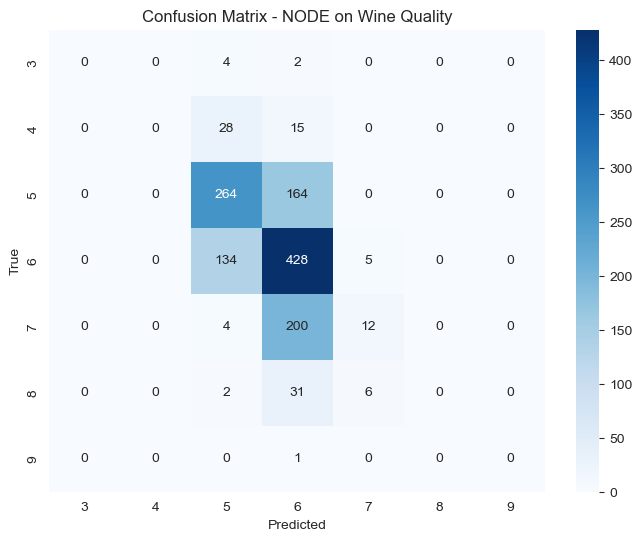

In [14]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

le = LabelEncoder()
y_all = le.fit_transform(df['quality'])

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']


# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Separate rare classes (e.g., <10 samples)
y_series = pd.Series(y_train).reset_index(drop=True)
X_df = pd.DataFrame(X_train_scaled).reset_index(drop=True)

class_counts = y_series.value_counts()
rare_classes = class_counts[class_counts < 1000].index.tolist()

# 4. Split training data: SMOTE-safe vs rare
mask = ~y_series.isin(rare_classes)
X_safe = X_df[mask].values
y_safe = y_series[mask].values

X_rare = X_df[~mask].values
y_rare = y_series[~mask].values

# 5. Apply SMOTE on SMOTE-safe subset only
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_safe, y_safe)

# 6. Combine all: original + resampled
X_train_final = np.vstack([X_train_scaled, X_smote])
y_train_final = np.hstack([y_train, y_smote])

input_dim = X_train_final.shape[1]
num_classes = len(set(y_train_final))

model = nn.Sequential(
    ODST(
        in_features=input_dim,
        num_trees=64,
        depth=6,
        tree_dim=3,
        flatten_output=True
    ),
    nn.Linear(64 * 3, num_classes)
)
train_dataset = TensorDataset(torch.tensor(X_train_final, dtype=torch.float32),
                              torch.tensor(y_train_final, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
# Prepare test data
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred_probs = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_probs, dim=1).numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - NODE on Wine Quality")
plt.show()

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
def objective(trial):
    # 1) Sample hyperparameters
    num_trees     = trial.suggest_categorical("num_trees",    [32, 64, 128, 256])
    depth         = trial.suggest_int("depth",               4,   8)
    tree_dim      = trial.suggest_int("tree_dim",            1,   4)
    lr            = trial.suggest_loguniform("lr",            1e-4, 1e-2)
    batch_size    = trial.suggest_categorical("batch_size",   [128, 256, 512])

    # 2) Build model
    input_dim = X_train_final.shape[1]
    num_classes = len(np.unique(y_train_final))
    model = nn.Sequential(
        ODST(
            in_features=input_dim,
            num_trees=num_trees,
            depth=depth,
            tree_dim=tree_dim,
            flatten_output=True
        ),
        nn.Linear(num_trees * tree_dim, num_classes)
    ).to(device)

    # 3) Split train→ train/val
    ds = TensorDataset(
        torch.tensor(X_train_final, dtype=torch.float32),
        torch.tensor(y_train_final, dtype=torch.long)
    )
    n_val = int(len(ds) * 0.2)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)

    # 4) Train for a few epochs
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(5):         # small number to keep tuning fast
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # 5) Evaluate on validation set
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.append(out.argmax(dim=1).cpu().numpy())
            targets.append(yb.numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    acc = accuracy_score(targets, preds)

    return acc

# 6) Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

[I 2025-05-20 14:50:11,504] A new study created in memory with name: no-name-33231435-a749-44bd-b324-46e9951054ce
/var/folders/q9/ptykc9zs65n_zq5t8sqq8xqr0000gn/T/ipykernel_1468/1427447143.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr            = trial.suggest_loguniform("lr",            1e-4, 1e-2)
/Users/ozgun/Desktop/cs454/CS454-Project/src/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."
[I 2025-05-20 14:50:20,663] Trial 0 finished with value: 0.61273

Best trial:
{'num_trees': 128, 'depth': 7, 'tree_dim': 4, 'lr': 0.007207066773707198, 'batch_size': 128}
